In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import interp1d
#import psi4

This notebook goes through the process of determining the single amount of HFX that minimizes the loss function $J(\alpha) = (IP + \varepsilon_{HOMO})^2 + (EA + \varepsilon_{LUMO})^2$. Plots to visualize the optimization are also presented. We also analyze the number of points with sufficient data to IP tune.

# Determining Optimal Single HFX

In [2]:
data = pd.read_csv('../data/optimal_tuning.csv').set_index('Unnamed: 0')
structs = data.index

def interp(prop, spin, func, struct):
    '''
    Given a property, spin state, functional, and a structure name, returns a function that interpolates the HFX range for that functional.
    '''
    x = []
    y = []
    for hfx in np.arange(0, 101, 5):
        yval = data[str(hfx) + f' {prop} {spin} {func}'][struct]
        if not np.isnan(yval):
            x.append(hfx)
            y.append(yval)
    if len(x) < 5:
        return np.nan
    return interp1d(x, y, kind='linear', fill_value='extrapolate')

#note that the IP and EA dataframes are defined with the opposite sign convention \
#to the objective function where HOMO=IP, LUMO=EA, so we negate them in the objective function below.

def objective(spin, func, structure, hfx):
    homo = interp('HOMO', spin, func, structure)
    if callable(homo):
        homo = homo(hfx)
    lumo = interp('LUMO', spin, func, structure)
    if callable(lumo):
        lumo = lumo(hfx)
    ip = interp('IP', spin, func, structure)
    if callable(ip):
        ip = ip(hfx)
    ea = interp('EA', spin, func, structure)
    if callable(ea):
        ea = ea(hfx)
    return (homo + ip)**2 + (lumo + ea)**2

# 4 cases, LS SCAN, HS SCAN, LS PBE, HS PBE

In [3]:
LS_scan_df = pd.DataFrame(index=structs, columns=['Tuned'])

for struct in tqdm(structs):
    fun = lambda hfx: objective('LS', 'SCAN', struct, hfx)
    if np.isnan(fun(50)):
        LS_scan_df.loc[struct] = np.nan
    else:
        res = minimize(fun, [25], bounds=((0, 100),), method='Nelder-Mead')
        if res.success:
            LS_scan_df.loc[struct] = res.x.flatten()
        else:
            print(f'{struct} did not converge for LS SCAN')

HS_scan_df = pd.DataFrame(index=structs, columns=['Tuned'])

for struct in tqdm(structs):
    fun = lambda hfx: objective('HS', 'SCAN', struct, hfx)
    if np.isnan(fun(50)):
        HS_scan_df.loc[struct] = np.nan
    else:
        res = minimize(fun, [25], bounds=((0, 100),), method='Nelder-Mead')
        if res.success:
            HS_scan_df.loc[struct] = res.x.flatten()
        else:
            print(f'{struct} did not converge for HS SCAN')

LS_pbe_df = pd.DataFrame(index=structs, columns=['Tuned'])

for struct in tqdm(structs):
    fun = lambda hfx: objective('LS', 'PBE', struct, hfx)
    if np.isnan(fun(50)):
        LS_pbe_df.loc[struct] = np.nan
    else:
        res = minimize(fun, [25], bounds=((0, 100),), method='Nelder-Mead')
        if res.success:
            LS_pbe_df.loc[struct] = res.x.flatten()
        else:
            print(f'{struct} did not converge for LS PBE')

HS_pbe_df = pd.DataFrame(index=structs, columns=['Tuned'])

for struct in tqdm(structs):
    fun = lambda hfx: objective('HS', 'PBE', struct, hfx)
    if np.isnan(fun(50)):
        HS_pbe_df.loc[struct] = np.nan
    else:
        res = minimize(fun, [25], bounds=((0, 100),), method='Nelder-Mead')
        if res.success:
            HS_pbe_df.loc[struct] = res.x.flatten()
        else:
            print(f'{struct} did not converge for HS PBE')

scan_df = LS_scan_df.join(HS_scan_df, lsuffix=' LS', rsuffix=' HS')
pbe_df = LS_pbe_df.join(HS_pbe_df, lsuffix=' LS', rsuffix=' HS')
tuned_df = pbe_df.join(scan_df, lsuffix=' PBE', rsuffix=' SCAN')
tuned_df.to_csv('../data/tuned_targets.csv')

100%|███████████████████████████████████████████| 72/72 [00:06<00:00, 10.93it/s]


Co_ADETCO_comp_0_3111
Co_ADETCO_comp_0_3111


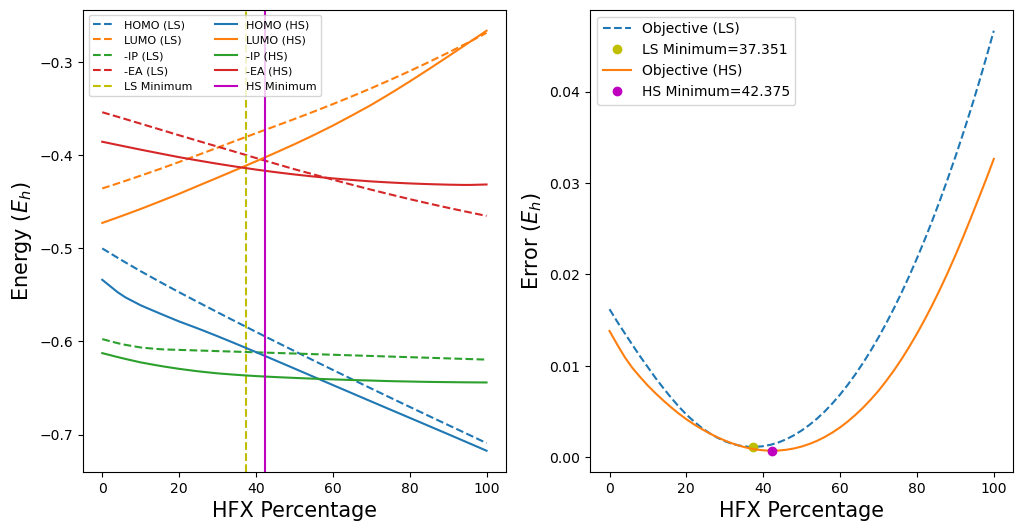

In [5]:
# example visualization

struct = structs[0]

x = np.arange(0, 101, 2)

fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

homo_func = interp('HOMO', 'LS', 'SCAN', struct)
lumo_func = interp('LUMO', 'LS', 'SCAN', struct)
ip_func = interp('IP', 'LS', 'SCAN', struct)
ea_func = interp('EA', 'LS', 'SCAN', struct)
axs[0].plot(x, homo_func(x), label='HOMO (LS)', color='C0', ls='--')
axs[0].plot(x, lumo_func(x), label='LUMO (LS)', color='C1', ls='--')
axs[0].plot(x, -ip_func(x), label='-IP (LS)', color='C2', ls='--')
axs[0].plot(x, -ea_func(x), label='-EA (LS)', color='C3', ls='--')
#axs[0].plot(x, homo_func(x) + ip_func(x), label='HOMO+IP')
#axs[0].plot(x, lumo_func(x) + ea_func(x), label='LUMO+EA')
#axs[0].legend()
fun = lambda hfx: objective('LS', 'SCAN', struct, hfx)
axs[1].plot(x, fun(x), label='Objective (LS)', ls='--')

min = LS_scan_df.loc[struct].item()
plt.plot(min, fun(min), 'o', label=f'LS Minimum={min:1.3f}', color='y')
axs[1].legend()
axs[0].axvline(min, ls='--', label='LS Minimum', color='y')

print(struct)

# example visualization

struct = structs[0]

x = np.arange(0, 101, 2)

homo_func = interp('HOMO', 'HS', 'SCAN', struct)
lumo_func = interp('LUMO', 'HS', 'SCAN', struct)
ip_func = interp('IP', 'HS', 'SCAN', struct)
ea_func = interp('EA', 'HS', 'SCAN', struct)
axs[0].plot(x, homo_func(x), label='HOMO (HS)', color='C0', ls='-')
axs[0].plot(x, lumo_func(x), label='LUMO (HS)', color='C1', ls='-')
axs[0].plot(x, -ip_func(x), label='-IP (HS)', color='C2', ls='-')
axs[0].plot(x, -ea_func(x), label='-EA (HS)', color='C3', ls='-')
#axs[0].plot(x, homo_func(x) + ip_func(x), label='HOMO+IP')
#axs[0].plot(x, lumo_func(x) + ea_func(x), label='LUMO+EA')
#axs[0].legend()
fun = lambda hfx: objective('HS', 'SCAN', struct, hfx)
axs[1].plot(x, fun(x), label='Objective (HS)')

min = HS_scan_df.loc[struct].item()
plt.plot(min, fun(min), 'o', label=f'HS Minimum={min:1.3f}', color='m')
axs[1].legend()
axs[0].axvline(min, ls='-', label='HS Minimum', color='m')
axs[0].legend(loc='upper left', prop={'size':8}, ncols=2)
axs[0].set_xlabel('HFX Percentage', fontsize=15)
axs[0].set_ylabel(r'Energy ($E_h$)', fontsize=15)
axs[1].set_xlabel('HFX Percentage', fontsize=15)
axs[1].set_ylabel(r'Error ($E_h$)', fontsize=15)

print(struct)

# Determining the Number of Structures in the Set

In [10]:
#before filtering out structures not in CSD-76
print(f'The number of structures removed for LS PBE is {np.sum(pd.isna(tuned_df["Tuned LS PBE"]))}.')
print(f'The number of structures removed for HS PBE is {np.sum(pd.isna(tuned_df["Tuned HS PBE"]))}.')
print(f'The number of structures removed for either PBE is {np.sum(pd.isna(tuned_df["Tuned LS PBE"] + tuned_df["Tuned HS PBE"]))}.')

print(f'The number of structures removed for LS SCAN is {np.sum(pd.isna(tuned_df["Tuned LS SCAN"]))}.')
print(f'The number of structures removed for HS SCAN is {np.sum(pd.isna(tuned_df["Tuned HS SCAN"]))}.')
print(f'The number of structures removed for either SCAN is {np.sum(pd.isna(tuned_df["Tuned LS SCAN"] + tuned_df["Tuned HS SCAN"]))}.')

The number of structures removed for LS PBE is 5.
The number of structures removed for HS PBE is 7.
The number of structures removed for either PBE is 11.
The number of structures removed for LS SCAN is 11.
The number of structures removed for HS SCAN is 6.
The number of structures removed for either SCAN is 14.


In [14]:
#after filtering out structures not in CSD-76
csd_targets = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')
df = csd_targets.join(tuned_df)

print(f'The number of structures removed for LS PBE is {np.sum(pd.isna(df["hfx_pbe"]+df["Tuned LS PBE"]))}.')
print(f'The number of structures removed for HS PBE is {np.sum(pd.isna(df["hfx_pbe"]+df["Tuned HS PBE"]))}.')
print(f'The number of structures removed for either PBE is {np.sum(pd.isna(df["hfx_pbe"]+df["Tuned LS PBE"]+df["Tuned HS PBE"]))}.')

print(f'The number of structures removed for LS SCAN is {np.sum(pd.isna(df["hfx_scan"]+df["Tuned LS SCAN"]))}.')
print(f'The number of structures removed for HS SCAN is {np.sum(pd.isna(df["hfx_scan"]+df["Tuned HS SCAN"]))}.')
print(f'The number of structures removed for either SCAN is {np.sum(pd.isna(df["hfx_scan"]+df["Tuned LS SCAN"]+df["Tuned HS SCAN"]))}.')

The number of structures removed for LS PBE is 7.
The number of structures removed for HS PBE is 9.
The number of structures removed for either PBE is 12.
The number of structures removed for LS SCAN is 14.
The number of structures removed for HS SCAN is 11.
The number of structures removed for either SCAN is 17.
